# MMF Utils

Small set of utilities: containers and interfaces.

This package provides some utilities that I tend to rely on during development.  Presently it includes some convenience containers, plotting tools, and a patch for including [zope.interface](http://docs.zope.org/zope.interface/) documentation in a notebook.

(Note: If this file does not render properly, try viewing it through [nbviewer.org](http://nbviewer.ipython.org/urls/bitbucket.org/mforbes/mmfutils-fork/raw/tip/doc/README.ipynb))

**Documentation:**
   http://mmfutils.readthedocs.org

**Source:**

 * https://alum.mit.edu/www/mforbes/hg/forbes-group/mmfutils: Permalink (will forward).
 * https://hg.iscimath.org/forbes-group/mmfutils: Current, in case the permalink fails.
 * https://github.com/forbes-group/mmfutils: Public read-only mirror.

**Issues:**
 https://alum.mit.edu/www/mforbes/hg/forbes-group/mmfutils/issues

**Build Status**

[![Documentation Status](https://readthedocs.org/projects/mmfutils/badge/?version=latest)](https://mmfutils.readthedocs.io/en/latest/?badge=latest)
[![Build Status](https://cloud.drone.io/api/badges/forbes-group/mmfutils/status.svg)](https://cloud.drone.io/forbes-group/mmfutils)

## Installing

This package can be installed from [PyPI](https://pypi.org/project/mmfutils/):

```bash
python3 -m pip install mmfutils
python3 -m pip install mmfutils[fftw]   # If you have the FFTW libraries installed
```

or, if you need to install from source, you can get it from one of the repositories:

```bash
python3 -m pip install hg+https://alum.mit.edu/www/mforbes/hg/forbes-group/mmfutils
python3 -m pip install git+https://github.com/forbes-group/mmfutils
```

# Usage

## Containers

### ObjectBase and Object

The `ObjectBase` and `Object` classes provide some useful features described below. Consider a problem where a class is defined through a few parameters, but requires extensive initialization before it can be properly used.  An example is a numerical simulation where one passes the number of grid points $N$ and a length $L$, but the initialization must generate large grids for efficient use later on.  These grids should be generated before computations begin, but should not be re-generated every time needed.  They also should not be pickled when saved to disk.

**Deferred initialization via the `init()` method:** The idea here changes the semantics of `__init__()` slightly by deferring any expensive initialization to `init()`.  Under this scheme, `__init__()` should only set and check what we call picklable attributes: these are parameters that define the object (they will be pickled in `Object` below) and will be stored in a list `self.picklable_attributes` which is computed at the end of `ObjectBase.__init__()` as the list of all keys in `__dict__`.  Then, `ObjectBase.__init__()` will call `init()` where all remaining attributes should be calculated.

This allows users to change various attributes, then reinitialize the object once with an explicit call to `init()` before performing expensive computations.  This is an alternative to providing complete properties (getters and setters) for objects that need to trigger computation.  The use of setters is safer, but requires more work on the side of the developer and can lead to complex code when different properties depend on each other.  The approach here puts all computations in a single place.  Of course, the user must remember to call `init()` before working with the object.

To facilitate this, we provide a mild check in the form of an `initialized` flag that is set to `True` at the end of the base `init()` chain, and set to `False` if any variables are in `pickleable_attributes` are set.

**Serialization and Deferred Initialization:**
The base class `ObjectBase` does not provide any pickling services but does provide a nice representation.  Additional functionality is provided by `Object` which uses the features of `ObjectBase` to define `__getstate__()` and `__setstate__()` methods for pickling which pickle only the `picklable_attributes`.  Note: unpickling an object will **not** call `__init__()` but will call `init()` giving objects a chance to restore the computed attributes from pickles.

* **Note:** *Before using, consider if these features are really needed – with all such added functionality comes additional potential failure modes from side-interactions. The `ObjectBase` class is quite simple, and therefore quite safe, while `Object` adds additional functionality with potential side-effects.  For example, a side-effect of support for pickles is that `copy.copy()` will also invoke `init()` when copying might instead be much faster.  Thus, we recommend only using `ObjectBase` for efficient code.*

#### Object Example

In [1]:
ROOTDIR = !hg root
ROOTDIR = ROOTDIR[0]
import sys

sys.path.insert(0, ROOTDIR)

import numpy as np

from mmfutils.containers import ObjectBase, ObjectMixin


class State(ObjectBase):
    _quiet = False

    def __init__(self, N, L=1.0, **kw):
        """Set all of the picklable parameters, in this case, N and L."""
        self.N = N
        self.L = L

        # Now register these and call init()
        super().__init__(**kw)
        if not self._quiet:
            print("__init__() called")

    def init(self):
        """All additional initializations"""
        if not self._quiet:
            print("init() called")
        dx = self.L / self.N
        self.x = np.arange(self.N, dtype=float) * dx - self.L / 2.0
        self.k = 2 * np.pi * np.fft.fftfreq(self.N, dx)

        # Set highest momentum to zero if N is even to
        # avoid rapid oscillations
        if self.N % 2 == 0:
            self.k[self.N // 2] = 0.0

        # Calls base class which sets self.initialized
        super().init()

    def compute_derivative(self, f):
        """Return the derivative of f."""
        return np.fft.ifft(self.k * 1j * np.fft.fft(f)).real


s = State(256)
print(s)  # No default value for L

init() called
__init__() called
State(L=1.0, N=256)


In [2]:
s.L = 2.0
print(s)

State(L=2.0, N=256)


One feature is that a nice ``repr()`` of the object is produced.  Now let's do a calculation:

In [3]:
f = np.exp(3 * np.cos(2 * np.pi * s.x / s.L)) / 15
df = (
    -2.0
    * np.pi
    / 5.0
    * np.exp(3 * np.cos(2 * np.pi * s.x / s.L))
    * np.sin(2 * np.pi * s.x / s.L)
    / s.L
)
np.allclose(s.compute_derivative(f), df)

False

Oops!  We forgot to reinitialize the object... (The formula is correct, but the lattice is no longer commensurate so the FFT derivative has huge errors).

In [4]:
print(s.initialized)
s.init()
assert s.initialized
f = np.exp(3 * np.cos(2 * np.pi * s.x / s.L)) / 15
df = (
    -2.0
    * np.pi
    / 5.0
    * np.exp(3 * np.cos(2 * np.pi * s.x / s.L))
    * np.sin(2 * np.pi * s.x / s.L)
    / s.L
)
np.allclose(s.compute_derivative(f), df)

False
init() called


True

Here we demonstrate pickling.  Note that using `Object` makes the pickles very small, and when unpickled, ``init()`` is called to re-establish ``s.x`` and ``s.k``.  Generally one would inherit from `Object`, but since we already have a class, we can provide pickling functionality with `ObjectMixin`:

In [5]:
class State1(ObjectMixin, State):
    pass


s = State(N=256, _quiet=True)
s1 = State1(N=256, _quiet=True)

In [6]:
import pickle, copy

In [7]:
s_repr = pickle.dumps(s)
s1_repr = pickle.dumps(s1)
print(f"ObjectBase pickle:  {len(s_repr)} bytes")
print(f"ObjectMixin pickle: {len(s1_repr)} bytes")

ObjectBase pickle:  4396 bytes
ObjectMixin pickle: 103 bytes


Note, however, that the speed of copying is significantly impacted:

In [8]:
%timeit copy.copy(s)
%timeit copy.copy(s1)

2.99 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
29.8 µs ± 951 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Another use case applies when ``init()`` is expensive.  If $x$ and $k$ were computed in ``__init__()``, then using properties to change both $N$ and $L$ would trigger two updates.  Here we do the updates, then call ``init()``.  Good practice is to call ``init()`` automatically before any serious calculation to ensure that the object is brought up to date before the computation.

In [9]:
s.N = 64
s.L = 2.0
s.init()

Finally, we demonstrate that ``Object`` instances can be archived using the ``persist`` package:

In [10]:
import persist.archive

a = persist.archive.Archive(check_on_insert=True)
a.insert(s=s)

d = {}
exec(str(a), d)

d["s"]

State(L=2.0, N=64, _quiet=True)

### Container

The ``Container`` object is a slight extension of ``Object`` that provides a simple container for storing data with attribute and iterative access. These implement some of the [Collections Abstract Base Classes from the python standard library](https://docs.python.org/2/library/collections.html#collections-abstract-base-classes). The following containers are provided:

- ``Container``: Bare-bones container extending the ``Sized``, ``Iterable``, and ``Container`` abstract ase classes (ABCs) from the standard ``containers`` library.
- ``ContainerList``: Extension that acts like a tuple/list satisfying the ``Sequence`` ABC from the ``containers`` library (but not the ``MutableSequence`` ABC.  Although we allow setting and deleting items, we do not provide a way for insertion, which breaks this interface.)
- ``ContainerDict``: Extension that acts like a dict satisfying the ``MutableMapping`` ABC from the ``containers`` library.

These were designed with the following use cases in mind:

- Returning data from a function associating names with each data.  The resulting ``ContainerList`` will act like a tuple, but will support attribute access.  Note that the order will be lexicographic.  One could use a dictionary, but attribute access with tab completion is much nicer in an interactive session.  The ``containers.nametuple`` generator could also be used, but this is somewhat more complicated (though might be faster).  Also, named tuples are immutable - here we provide a mutable object that is picklable etc.  The choice between ``ContainerList`` and ``ContainerDict`` will depend on subsequent usage.  Containers can be converted from one type to another.

#### Container Examples

In [11]:
from mmfutils.containers import Container

c = Container(a=1, c=2, b="Hi there")
print(c)
print(tuple(c))

Container(a=1, b='Hi there', c=2)
(1, 'Hi there', 2)


In [12]:
# Attributes are mutable
c.b = "Ho there"
print(c)

Container(a=1, b='Ho there', c=2)


In [13]:
# Other attributes can be used for temporary storage but will not be pickled.
import numpy as np

c.large_temporary_array = np.ones((256, 256))
print(c)
print(c.large_temporary_array)

Container(a=1, b='Ho there', c=2)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [14]:
import pickle

In [15]:
c1 = pickle.loads(pickle.dumps(c))
print(c1)
c1.large_temporary_array

Container(a=1, b='Ho there', c=2)


AttributeError: 'Container' object has no attribute 'large_temporary_array'

## Contexts

The ``mmfutils.contexts`` module provides two useful contexts:

``NoInterrupt``: This can be used to susspend ``KeyboardInterrupt`` exceptions until they can be dealt with at a point that is convenient.  A typical use is when performing a series of calculations in a loop.  By placing the loop in a ``NoInterrupt`` context, one can avoid an interrupt from ruining a calculation:

In [16]:
from mmfutils.contexts import NoInterrupt

complete = False
n = 0
with NoInterrupt() as interrupted:
    while not complete and not interrupted:
        n += 1
        if n > 10:
            complete = True

Note: One can nest ``NoInterrupt`` contexts so that outer loops are also interrupted.  Another use-case is mapping.  See [doc/Animation.ipynb](Animation.ipynb) for more examples.

In [17]:
res = NoInterrupt().map(abs, range(-100, 100))
np.sign(res)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

## Interfaces

The interfaces module collects some useful [zope.interface](http://docs.zope.org/zope.interface/) tools for checking interface requirements.  Interfaces provide a convenient way of communicating to a programmer what needs to be done to used your code.  This can then be checked in tests.

In [18]:
from mmfutils.interface import (
    Interface,
    Attribute,
    verifyClass,
    verifyObject,
    implementer,
)


class IAdder(Interface):
    """Interface for objects that support addition."""

    value = Attribute("value", "Current value of object")

    # No self here since this is the "user" interface
    def add(other):
        """Return self + other."""

Here is a broken implementation. We muck up the arguments to ``add``:

In [19]:
@implementer(IAdder)
class AdderBroken(object):
    def add(self, one, another):
        # There should only be one argument!
        return one + another


try:
    verifyClass(IAdder, AdderBroken)
except Exception as e:
    print("{0.__class__.__name__}: {0}".format(e))


BrokenMethodImplementation: The object <class '__main__.AdderBroken'> has failed to implement interface __main__.IAdder: The contract of __main__.IAdder.add(other) is violated because 'AdderBroken.add(self, one, another)' requires too many arguments.


Now we get ``add`` right, but forget to define ``value``.  This is only caught when we have an object since the attribute is supposed to be defined in ``__init__()``:

In [20]:
@implementer(IAdder)
class AdderBroken(object):
    def add(self, other):
        return one + other


# The class validates...
verifyClass(IAdder, AdderBroken)

# ... but objects are missing the value Attribute
try:
    verifyObject(IAdder, AdderBroken())
except Exception as e:
    print("{0.__class__.__name__}: {0}".format(e))

BrokenImplementation: The object <__main__.AdderBroken object at 0x11558c1c0> has failed to implement interface __main__.IAdder: The __main__.IAdder.value attribute was not provided.


Finally, a working instance:

In [21]:
@implementer(IAdder)
class Adder(object):
    def __init__(self, value=0):
        self.value = value

    def add(self, other):
        return one + other


verifyClass(IAdder, Adder) and verifyObject(IAdder, Adder())

True

### Interface Documentation

We also monkeypatch ``zope.interface.documentation.asStructuredText()`` to provide a mechanism for documentating interfaces in a notebook.

In [22]:
from mmfutils.interface import describe_interface

In [23]:
describe_interface(IAdder)

## Parallel

The ``mmfutils.parallel`` module provides some tools for launching and connecting to IPython clusters.  The ``parallel.Cluster`` class represents and controls a cluster.  The cluster is specified by the profile name, and can be started or stopped from this class:

In [24]:
import logging

In [25]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import numpy as np
from mmfutils import parallel

In [26]:
cluster = parallel.Cluster(profile="default", n=3, sleep_time=1.0)
cluster.start()
cluster.wait()  # Instance of IPython.parallel.Client
view = cluster.load_balanced_view
x = np.linspace(-6, 6, 100)
y = view.map(lambda x: x**2, x)
print(np.allclose(y, x**2))
cluster.stop()

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


INFO:root:Starting cluster: ipcluster start --daemonize --quiet --profile=default --n=3
Leaving cluster running: /Users/mforbes/.ipython/profile_default/security/cluster-.json
INFO:root:waiting for 3 engines
INFO:root:0 of 3 running
INFO:root:3 of 3 running
INFO:root:Stopping cluster: ipcluster stop --profile=default


True


2022-06-07 11:37:19.290 [IPClusterStop] Stopping cluster 
2022-06-07 11:37:19.290 [IPClusterStop] Stopping controller
2022-06-07 11:37:19.432 [IPClusterStop] Controller stopped: {'exit_code': None, 'pid': 8883, 'identifier': 'ipcontroller-8934'}
2022-06-07 11:37:19.434 [IPClusterStop] Stopping engine(s): 1654627030
2022-06-07 11:37:19.857 [IPClusterStop] engine set stopped 1654627030: {'engines': {'0': {'exit_code': None, 'pid': 8896, 'identifier': '0'}, '1': {'exit_code': None, 'pid': 8897, 'identifier': '1'}, '2': {'exit_code': None, 'pid': 8898, 'identifier': '2'}}, 'exit_code': None}


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


If you only need a cluster for a single task, it can be managed with a context.  Be sure to wait for the result to be computed before exiting the context and shutting down the cluster!

In [27]:
with parallel.Cluster(profile="default", n=3, sleep_time=1.0) as client:
    view = client.load_balanced_view
    x = np.linspace(-6, 6, 100)
    y = view.map(lambda x: x**2, x, block=True)  # Make sure to wait for the result!
print(np.allclose(y, x**2))

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


INFO:root:Starting cluster: ipcluster start --daemonize --quiet --profile=default --n=3
Leaving cluster running: /Users/mforbes/.ipython/profile_default/security/cluster-.json
INFO:root:waiting for 3 engines
INFO:root:0 of 3 running
INFO:root:3 of 3 running
INFO:root:Stopping cluster: ipcluster stop --profile=default
2022-06-07 11:38:27.128 [IPClusterStop] Stopping cluster 
2022-06-07 11:38:27.129 [IPClusterStop] Stopping controller
2022-06-07 11:38:27.279 [IPClusterStop] Controller stopped: {'exit_code': None, 'pid': 8997, 'identifier': 'ipcontroller-9044'}
2022-06-07 11:38:27.281 [IPClusterStop] Stopping engine(s): 1654627098
2022-06-07 11:38:27.710 [IPClusterStop] engine set stopped 1654627098: {'engines': {'0': {'exit_code': None, 'pid': 9010, 'identifier': '0'}, '1': {'exit_code': None, 'pid': 9011, 'identifier': '1'}, '2': {'exit_code': None, 'pid': 9015, 'identifier': '2'}}, 'exit_code': None}


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
True


If you just need to connect to a running cluster, you can use ``parallel.get_client()``.

## Performance

The ``mmfutils.performance`` module provides some tools for high performance computing.  Note: this module requires some additional packages including [numexp](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide), [pyfftw](http://hgomersall.github.io/pyFFTW/), and the ``mkl`` package installed by anaconda.  Some of these require building system libraries (i.e. the [FFTW](http://www.fftw.org)).  However, the various components will not be imported by default.

Here is a brief description of the components:

* ``mmfutils.performance.blas``: Provides an interface to a few of the scipy BLAS wrappers.  Very incomplete (only things I currently need).
* ``mmfutils.performance.fft``: Provides an interface to the [FFTW](http://www.fftw.org) using ``pyfftw`` if it is available.  Also enables the planning cache and setting threads so you can better control your performance.
* ``mmfutils.performance.numexpr``: Robustly imports numexpr and disabling the VML.  (If you don't do this carefully, it will crash your program so fast you won't even get a traceback.)
* ``mmfutils.performance.threads``: Provides some hooks for setting the maximum number of threads in a bunch of places including the MKL, numexpr, and fftw.

## Plotting

Several tools are provided in `mmfutils.plot`:

### Fast Filled Contour Plots

`mmfutils.plot.imcontourf` is similar to matplotlib's `plt.contourf` function, but uses `plt.imshow` which is much faster.  This is useful for animations and interactive work.  It also supports my idea of saner array-shape processing (i.e. if `x` and `y` have different shapes, then it will match these to the shape of `z`).  Matplotlib now provides `plt.pcolourmesh` which is similar, but has the same interface issues.

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
import numpy as np
from mmfutils import plot as mmfplt

CPU times: user 10 ms, sys: 2.64 ms, total: 12.7 ms
Wall time: 12.7 ms
CPU times: user 101 ms, sys: 1.65 ms, total: 103 ms
Wall time: 104 ms
CPU times: user 135 ms, sys: 6.21 ms, total: 141 ms
Wall time: 141 ms
CPU times: user 3.59 ms, sys: 176 µs, total: 3.77 ms
Wall time: 3.74 ms


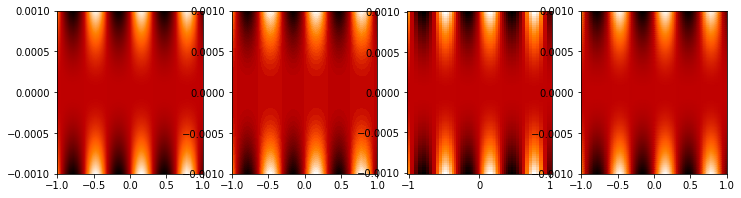

In [29]:
x = np.linspace(-1, 1, 100)[:, None] ** 3
y = np.linspace(-0.1, 0.1, 200)[None, :] ** 3
z = np.sin(10 * x) * y**2
plt.figure(figsize=(12, 3))
plt.subplot(141)
%time mmfplt.imcontourf(x, y, z, cmap='gist_heat')
plt.subplot(142)
%time plt.contourf(x.ravel(), y.ravel(), z.T, 50, cmap='gist_heat')
plt.subplot(143)
%time plt.pcolor(x.ravel(), y.ravel(), z.T, cmap='gist_heat', shading='auto')
plt.subplot(144)
%time plt.pcolormesh(x.ravel(), y.ravel(), z.T, cmap='gist_heat', shading='gouraud')

## Angular Variables

A couple of tools are provided to visualize angular fields, such as the phase of a complex wavefunction.

(<matplotlib.contour.QuadContourSet at 0x12506ca60>,
 <matplotlib.contour.QuadContourSet at 0x124036dc0>)

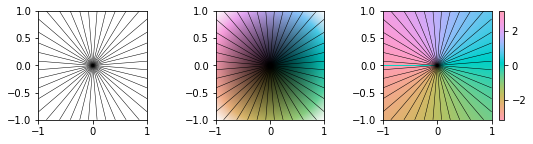

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
import numpy as np
from mmfutils import plot as mmfplt

x = np.linspace(-1, 1, 100)[:, None]
y = np.linspace(-1, 1, 200)[None, :]
z = x + 1j * y

plt.figure(figsize=(9, 2))
ax = plt.subplot(131)
mmfplt.phase_contour(x, y, z, colors="k", linewidths=0.5)
ax.set_aspect(1)

# This is a little slow but allows you to vary the luminosity.
ax = plt.subplot(132)
mmfplt.imcontourf(x, y, mmfplt.colors.color_complex(z))
mmfplt.phase_contour(x, y, z, linewidths=0.5)
ax.set_aspect(1)

# This is faster if you just want to show the phase and allows
# for a colorbar via a registered colormap
ax = plt.subplot(133)
mmfplt.imcontourf(x, y, np.angle(z), cmap="huslp")
ax.set_aspect(1)
plt.colorbar()
mmfplt.phase_contour(x, y, z, linewidths=0.5)

## Debugging

A couple of debugging tools are provided.  The most useful is the `debug` decorator which will store the local variables of a function in a dictionary or in your global scope.

In [31]:
from mmfutils.debugging import debug


@debug(locals())
def f(x):
    y = x**1.5
    z = 2 / x
    return z


print(f(2.0), x, y, z)

1.0 2.0 2.8284271247461903 1.0


## Mathematics

We include a few mathematical tools here too.  In particular, numerical integration and differentiation.  Check the API documentation for details.

# Developer Instructions

For Developer Notes, please see [Notes.md](../Notes.md).

Complete code coverage information is provided in ``build/_coverage/index.html``.

In [32]:
from IPython.display import HTML

In [33]:
with open(os.path.join(ROOTDIR, "build/_coverage/index.html")) as f:
    coverage = f.read()
HTML(coverage)

Module,statements,missing,excluded,coverage
src/mmfutils/__init__.py,20,4,0,80%
src/mmfutils/containers.py,113,2,0,98%
src/mmfutils/contexts.py,199,25,0,87%
src/mmfutils/debugging.py,49,0,3,100%
src/mmfutils/interface.py,77,0,15,100%
src/mmfutils/math/__init__.py,0,0,0,100%
src/mmfutils/math/bases/__init__.py,2,0,0,100%
src/mmfutils/math/bases/bases.py,458,58,0,87%
src/mmfutils/math/bases/interfaces.py,37,0,0,100%
src/mmfutils/math/bases/utils.py,40,11,0,72%


# Change Log

## REL: 0.6.6
* Fix issue #31: FFT falbacks should work even if pyfftw is not installed.  (Monkeypatch this case in `test_performance_fft.py`)
* Fix issue #32: Make copy of arrays before calling pyfftw builders for the convenience functions to ensure that everything works, even if they are not `WRITEABLE`.

## REL: 0.6.5

* Fix issue #30: measure fft performance and fallback to numpy (with a warning) if it is faster than pyfftw.

## REL: 0.6.4
* Support python 3.7.13 through 3.11.
* Fix some tests.
* Add `contexts.FPS` which is generally preferred to `NoInterrupt`.
* Add a `timeout=` argument to contexts.
* Unbind versions.
* Fix a couple of bugs in `math.bases.bases.py`:
  * Actually use `memoization_GB`.
  * `PeriodicBasis.kx` is now a property.

## REL: 0.6.3
* Fix some dependencies.

## REL: 0.6.2

* Fix some issues with GPU and PeriodicBases.
* Add warning to FFT plans about data ownership.
* Include some Sparkline demonstrations.
* Drop support for Python 3.6. (Still no support for 3.10).

## REL: 0.6.0

* Use Poetry for dependency management.
* Update to `src/mmfutils` layout.
* Better testing and coverage, including GitHub CI.
* Odd-numbered lattices are now centered at 0.
* Added `fftw` extra.

## REL: 0.5.4

* Drop support for Python 3.5.
* Use [Nox](https://nox.thea.codes) for testing (see [Notes.md](../Notes.md))

## REL: 0.5.3

Allow Python 3.8.  Previous version required `python <= 3.7` due to an [issue with ipyparallel](https://github.com/ipython/ipyparallel/issues/396).  This has been resolved with revision 6.2.5 which is available with `conda`.


## REL: 0.5.1

API changes:

* Split `mmfutils.containers.Object` into `ObjectBase` which is simple and `ObjectMixin` which provides the picking support.  Demonstrate in docs how the pickling can be useful, but slows copying.

## REL: 0.5.0

API changes:

* Python 3 support only.
* `mmfutils.math.bases.interface` renamed to `mmfutils.math.bases.interfaces`.
* Added default class-variable attribute support to e`mmfutils.containers.Object`.
* Minor enhancements to `mmfutils.math.bases.PeriodicBasis` to enhance GPU support.
* Added `mmfutils.math.bases.interfaces.IBasisLz` and support in `mmfutils.math.bases.bases.PeriodicBasis` for rotating frames.
* Cleanup of build environment and tests.
  * Single environment `_mmfutils` now used for testing and documentation.

## REL: 0.4.13

API changes:

* Use `@implementer()` class decorator rather than `classImplements` or `implements` in all interfaces.
* Improve `NoInterrupt` context.  Added `NoInterrupt.unregister()`: this allows `NoInterrupt` to work in a notebook cell even when the signal handlers are reset.  (But only works in that one cell.)
* Added Abel transform `integrate2` to Cylindrical bases.

Issues:

* Resolved issue #22: Masked arrays work with `imcontourf` etc.
* Resolved issue #23: `NoInterrupt` works well except in notebooks due to [ipykernel issue #328](https://github.com/ipython/ipykernel/issues/328).
* Resolved issue #24: Python 3 is now fully supported and tested.

## REL: 0.4.10

API changes:

* Added `contourf`, `error_line`, and `ListCollections` to `mmfutils.plot`.
* Added Python 3 support (still a couple of issues such as `mmfutils.math.integrate.ssum_inline`.)
* Added `mmf.math.bases.IBasisKx` and update `lagrangian` in bases to accept `k2` and `kx2` for modified dispersion control (along x).
* Added `math.special.ellipkinv`.
* Added some new `mmfutils.math.linalg` tools.

Issues:

* Resolved issue #20: `DyadicSum` and `scipy.optimize.nonlin.Jacobian`
* Resolved issue #22: imcontourf now respects masked arrays.
* Resolved issue #24: Support Python 3.


## REL: 0.4.9

*< incomplete >*

## REL: 0.4.7

API changes:

* Added `mmfutils.interface.describe_interface()` for inserting interfaces into documentation.
* Added some DVR basis code to `mmfutils.math.bases`.
* Added a diverging colormap and some support in `mmfutils.plot`.
* Added a Wigner Ville distribution computation in `mmfutils.math.wigner`
* Added `mmfutils.optimize.usolve` and `ubrentq` for finding roots with [`uncertanties`](https://pythonhosted.org/uncertainties/) support.

Issues:

* Resolve issue #8: Use [`ipyparallel`](https://github.com/ipython/ipyparallel) now.
* Resolve issue #9: Use [pytest](https://pytest.org) rather than `nose` (which is no longer supported).
* Resolve issue #10: PYFFTW wrappers now support negative `axis` and `axes` arguments.
* Address issue #11: Preliminary version of some DVR basis classes.
* Resolve issue #12: Added solvers with [`uncertanties`](https://pythonhosted.org/uncertainties/) support.